<a href="https://colab.research.google.com/github/michaeljf00/text_summarizer/blob/roham/BBCDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!unzip data.zip

In [4]:
pip -q install numpy seaborn pandas nltk tensorflow-gpu torch matplotlib transformers Iprogress sentencepiece

     |████████████████████████████████| 588.3 MB 23 kB/s 
     |████████████████████████████████| 5.8 MB 46.7 MB/s 
     |████████████████████████████████| 1.3 MB 68.7 MB/s 
     |████████████████████████████████| 6.0 MB 63.9 MB/s 
     |████████████████████████████████| 439 kB 72.3 MB/s 
     |████████████████████████████████| 1.7 MB 61.1 MB/s 
     |████████████████████████████████| 182 kB 76.5 MB/s 
     |████████████████████████████████| 7.6 MB 67.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.11.0 which is incompatible.
tensorflow 2.9.2 requires tensorboard<2.10,>=2.9, but you have tensorboard 2.11.0 which is incompatible.
tensorflow 2.9.2 requires tensorflow-estimator<2.10.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random

## BBC News Summary EDA
TODO: add general description here

### Data preperation
To get started please paste the BBC news dataset into a folder titled data in the local directory. Then delete 199.txt in the articles and summaries directory respectively due to corruption with these files.

In [6]:
def get_text_by_topic(directory_path):
    data = []
    count = 0
    for topic in os.listdir(directory_path):
        topic_path = os.path.join(directory_path, topic)
        if not os.path.isdir(topic_path):
          continue
        for file_path in os.listdir(topic_path):
            try:
                with open(f'{topic_path}/{file_path}', 'r', encoding="utf-8") as f:
                    data.append(( topic_path.split('/')[-1],f.read()))
                count+=1
            except UnicodeDecodeError:
                print(f'file {file_path} in {topic_path} is not readable')
                print(UnicodeDecodeError)
    df = pd.DataFrame(data, columns=['label','text'])
    print(f"Total Items loaded: {count}")
    return df
                      
articles_path = r"data/BBC News Summary/News Articles"
summaries_path = r"data/BBC News Summary/Summaries"

articles_df = get_text_by_topic(articles_path)
summaries_df = get_text_by_topic(summaries_path)
articles_df.head()

file .DS_Store in data/BBC News Summary/News Articles/sport is not readable
<class 'UnicodeDecodeError'>
Total Items loaded: 2224
file .DS_Store in data/BBC News Summary/Summaries/sport is not readable
<class 'UnicodeDecodeError'>
Total Items loaded: 2224


,label,text
0,business,JP Morgan admits US slavery links\n\nThousands...
1,business,"Barclays profits hit record level\n\nBarclays,..."
2,business,Japanese banking battle at an end\n\nJapan's S...
3,business,German business confidence slides\n\nGerman bu...
4,business,MG Rover China tie-up 'delayed'\n\nMG Rover's ...


### Lets see an example from the dataset

In [7]:
print("Articles Shape: ",articles_df.shape)
print("Summaries Shape: ",summaries_df.shape)
# If this fails the wrong number of aricles or summaries was loaded
assert(articles_df.shape == summaries_df.shape)

ex_idx = int(random.random()*articles_df.shape[0])
ex_topic = articles_df["label"][ex_idx]
print(f"\nRandom Example Article in {ex_topic}:")
print(articles_df["text"][ex_idx])
print(f"Random Example Summary in {ex_topic}:")
print(summaries_df["text"][ex_idx])

Articles Shape:  (2224, 2)
Summaries Shape:  (2224, 2)

Random Example Article in business:
Fed chief warning on US deficit

Federal Reserve chairman Alan Greenspan has warned that allowing huge US budget deficits to continue could have "severe" consequences.

Speaking to the House Budget Committee he urged Congress to take action to cut the deficit, such as increasing taxes. While the US economy is growing at a "reasonably good pace" he warned that budget concerns were clouding the economic outlook for the US. Pension and healthcare costs posed the greatest risks to the economy, he said.

The government program faces severe financial strains in coming decades as the massive baby-boom generation retires. "I fear that we may have already committed more physical resources to the baby-boom generation in its retirement years than our economy has the capacity to deliver. If existing promises need to be changed, those changes should be made sooner rather than later," Mr Greenspan said. He al

From this example we can see the dataset consists of BBC articles and co-responding summaries that are constructed in an extractive manner, that is, each summary is constructed by selecting a subset of the sentances in the original article.

In [8]:
# Null Checks
articles_df.isna().sum()
summaries_df.isna().sum()

label    0
text     0
dtype: int64

Next looking into the balance of each topic in the dataset

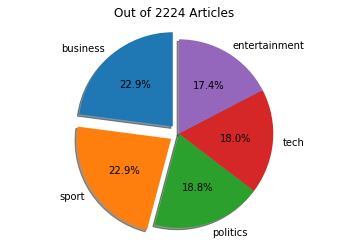

In [9]:
# Percent articles in each topic
label_vals = articles_df["label"].value_counts()

labels = list(label_vals.keys())
sizes = list(label_vals)
explode = [0]*len(sizes) 
explode[0] =0.1
explode[1] =0.1
fig1, ax1 = plt.subplots()
ax1.pie(label_vals, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Out of {articles_df.shape[0]} Articles")
plt.show()


The classes appear to be well balance so model performance should be equivelent across topics

99th percentile in sentance count:  63.0


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


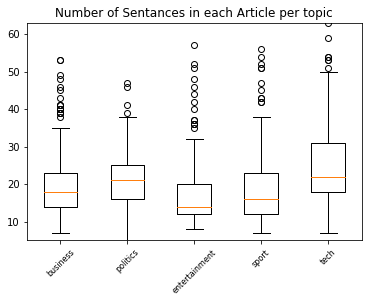

,business,politics,entertainment,sport,tech
count,510.000000,417.000000,386.000000,510.000000,401.000000
mean,19.680392,22.227818,17.945596,18.280392,25.842893
std,7.409560,15.467658,14.270836,9.876736,12.904370
min,7.000000,5.000000,8.000000,7.000000,7.000000
25%,14.000000,16.000000,12.000000,12.000000,18.000000
50%,18.000000,21.000000,14.000000,16.000000,22.000000
75%,23.000000,25.000000,20.000000,23.000000,31.000000
max,53.000000,246.000000,205.000000,82.000000,161.000000


In [10]:
# Number of Sentances in articles per topic
def get_text_length(daf, split):
    text_lens = [[len(t.split(split)) for t in daf["text"][daf['label'] == label]] for label in daf['label'].unique()]
    return text_lens

# Splitting on . for each sentance
text_lens = get_text_length(articles_df, ".")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in sentance count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Sentances in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

It appears that tech articles have the longest articles in terms of sentances however the categories seem to be balanced here aswell. Noteably there are some drastic outliars for article length with 200+ sentances that may have to be removed.

99th percentile in Word count:  475.0


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


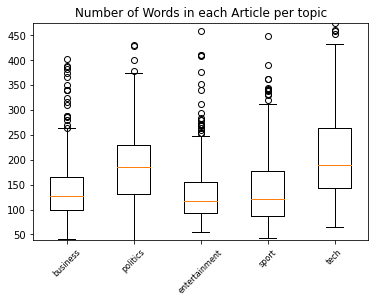

,business,politics,entertainment,sport,tech
count,510.00000,417.000000,386.00000,510.000000,401.000000
mean,139.94902,195.738609,144.07772,143.194118,213.880299
std,59.48480,139.855957,124.31821,80.966871,111.675336
min,40.00000,38.000000,54.00000,42.000000,65.000000
25%,99.00000,132.000000,93.25000,87.000000,144.000000
50%,127.00000,186.000000,117.00000,122.000000,189.000000
75%,164.75000,230.000000,154.75000,178.500000,264.000000
max,403.00000,2074.000000,1708.00000,659.000000,1433.000000


In [11]:
# Number of Words in articles per topic (splitting on " ")
text_lens = get_text_length(summaries_df, " ")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in Word count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Words in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

Comparing the word counts to the sentance counts we can see the same outliar issue exists as well as sports having less words despite having more sentances implying that sentance length will vary based on the topic.

### Next looking at the ground truth reduction in word count

In [12]:
# Summary length reduction per topic by word count
articles_len = get_text_length(articles_df, " ")
summaries_len = get_text_length(summaries_df, " ")


# For each Topic
print("Average percent reduction in words for ...")
for i,topic in enumerate(articles_df['label'].unique()):
    # 1  - ratio of summary to article length
    avg_percent_reduction = np.mean(1-np.asarray(summaries_len[i])/np.asarray(articles_len[i]))
    print(f"{topic} summaries: {100*avg_percent_reduction:0.4f}%")

Average percent reduction in words for ...
business summaries: 56.8027%
politics summaries: 56.5632%
entertainment summaries: 56.0781%
sport summaries: 55.5133%
tech summaries: 57.2868%


From this we see across the board roughly half of the words are dropped in the ground truth summaries implying our model should have a similar dropout rate. This also may indicate classification may be a valid approach to determining whether a sentance should remain in the summary. Running this code over with sentance count reveals a similar trend implying no relationship between sentance length and likelyhood to be in the summmary.

### EDA with common heuristics in NLP

In extractive text summarization a common baseline model is to simply take the first few sentances (typically 3) of a peice of text as the summary as writers often introduce their main points in the beggining of articles. We will analyze the effectiveness of this heuristic for the BBC model for possible consideration for a baseline model

In [13]:
# For regular expression
import re
# for sentance parsing
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# turn each article into a list of sentances
def get_sentances(texts_list):
    documents = []
    for text in texts_list:
        documents.append(sent_tokenize(text.replace("\n\n",". ").replace(".. ",". ").replace(".",". ").replace(".  ",". ")))
    return documents
    #return [[a.strip() for a in t.replace("\n\n",".").split(".") if a!=''] for t in texts_list]

# First sentance inclusion in summary
article_sentances = get_sentances(articles_df["text"])
summary_sentances = get_sentances(summaries_df["text"])

# Check how many sentances (up to the fourth) of the article are in the summary
counts = [0]*4
for a,s in zip(article_sentances,summary_sentances):
    for i in range(len(counts)):
        if a[i+1] in s:
            counts[i]+=1
        else:
            break
print(f"{100*counts[0]/len(article_sentances):0.2f}% Article summaries include the first sentance of the article")
print(f"{100*counts[1]/len(article_sentances):0.2f}% Article summaries include the first and second")
print(f"{100*counts[2]/len(article_sentances):0.2f}% Article summaries include the first, second, and third")
print(f"{100*counts[3]/len(article_sentances):0.2f}% Article summaries include the first, second, third and fourth")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


69.83% Article summaries include the first sentance of the article
36.29% Article summaries include the first and second
17.81% Article summaries include the first, second, and third
7.33% Article summaries include the first, second, third and fourth


From this a good baseline model to compare text summarization would simply be to use the first few sentances of each article as the summary. The performance of this method is best with including one to two sentances

In [14]:
# Rarity of words used

In [15]:
# Overall use of stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Most common words after stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
# Additional NLP statistics

## Base Line Model
From the EDA we found that an effective baseline model would be taking the first two sentances of the article as the predicted summary

In [17]:
# Each base line prediction is the first two sentaces of the article
def base_line_predict(articles_df):
    predictions = []
    article_sentances = get_sentances(articles_df["text"])
    for a in article_sentances:
        predictions.append(a[1:3])
    return predictions

pred = base_line_predict(articles_df)
print(f"Example baseline: {pred[0]}\n")
print(f"Example summary: {summary_sentances[0]}")

Example baseline: ['Thousands of slaves were accepted as collateral for loans by two banks that later became part of JP Morgan Chase.', 'The admission is part of an apology sent to JP Morgan staff after the bank researched its links to slavery in order to meet legislation in Chicago.']

Example summary: ['Thousands of slaves were accepted as collateral for loans by two banks that later became part of JP Morgan Chase.', 'Citizens Bank and Canal Bank are the two lenders that were identified.', 'The bank said that it is a "very different company than the Citizens and Canal Banks of the 1800s".', '"We apologise to the African-American community, particularly those who are descendants of slaves, and to the rest of the American public for the role that Citizens Bank and Canal Bank played.', '"The admission is part of an apology sent to JP Morgan staff after the bank researched its links to slavery in order to meet legislation in Chicago.']


## Preprocessing For Extractive Text Summarization

In [18]:
from nltk.tokenize import word_tokenize
def compare_sentances(sentance_a, sentance_b):
    tok_a = word_tokenize(sentance_a)
    tok_b = word_tokenize(sentance_b)
    matches = 0
    for tok in tok_a:
        if tok in tok_b:
            matches+=1
    return float(matches)/len(tok_a)
    
# Generate Label
def generate_labels(articles_df, summaries_df):
    article_sentances = get_sentances(articles_df["text"])
    summary_sentances = get_sentances(summaries_df["text"])
    labels = []
    count=0
    total_sentances = 0
    same = 0
    for article,summary in zip(article_sentances,summary_sentances):
        sentance_inclusion = []
        for sentance_a in article:
            if len(sentance_a)<3:
                continue
            in_summary = False
            for sentance_b in summary:
                if len(sentance_b)<3:
                    continue
                percent_match = compare_sentances(sentance_a, sentance_b)
                if percent_match > 0.95:
                    in_summary=True
                    break
            total_sentances+=1
            if in_summary:
                sentance_inclusion.append(1)
            else:
                sentance_inclusion.append(0)
        #print(np.sum(sentance_inclusion), len(summary))
        same+=np.sum(sentance_inclusion) == len(summary)
        count+=1
        print(f"Percent Complete: {100*count/len(article_sentances):0.2f}%",end="\r")
        #assert(np.sum(sentance_inclusion) == len(summary))
        #print(sentance_inclusion)
        labels.append(sentance_inclusion)
        #print(article)
        #print(summary)
        #assert(np.sum(sentance_inclusion) == len(summary))
        
    #print(total_sentances)
    print()
    print("Matching  labels ",same)
    print("Total ",len(article_sentances))
    print(f"Total Sentances processed {total_sentances}")
    return labels

#print(articles_df["text"][1])
y_labels = generate_labels(articles_df, summaries_df) 
print(np.sum(np.sum(y_labels)))

# Expand contractions
# lowercase
# Remove digits and words containing digits
# Remove punctuations
# Remove stop words

# Remove Contractions and other anomolies

# Vectorize sentance

Percent Complete: 100.00%
Matching  labels  1904
Total  2224
Total Sentances processed 46319
18601


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Preprocessing For Abstractive Text Summarization

In [36]:
# Import tokenizer from pretrained model
from transformers import AutoTokenizer, TFAutoModelWithLMHead, AutoModelForSeq2SeqLM

model_name = "t5-small"

model = TFAutoModelWithLMHead.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_tf_auto.py:608: FutureWarning: The class `TFAutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `TFAutoModelForCausalLM` for causal language models, `TFAutoModelForMaskedLM` for masked language models and `TFAutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid 

In [20]:
# MAX_INPUT_LENGTH = 512
# MAX_TARGET_LENGTH = 30

# def preprocess_function(article, summary):
#     model_inputs = tokenizer(
#         article,
#         max_length=MAX_INPUT_LENGTH,
#         truncation=True
#     )
#     labels = tokenizer(
#         summary,
#         max_length=MAX_TARGET_LENGTH,
#         truncation=True
#     )
#     #model_inputs["labels"] = articles["labels"]
#     return model_inputs

# for i in range(articles_df.shape[0]):
#     result = preprocess_function(articles_df["text"][0], summaries_df["text"][0])

In [114]:
def abstract_tokenize(tokenizer, input_data):
  inputs = []

  for i in range(input_data.shape[0]):
    inputs.append(tokenizer.encode("summarize: " + input_data["text"][i], # required prefix
                              return_tensors = "tf",
                              max_length = 512, # required max_length
                              truncation = True))

  # readout
  print("Tokenized", len(inputs), "entries")
  print()
  print("Sample tokenized input:")
  print(inputs[0])

  return inputs

In [115]:
tokenized_array = abstract_tokenize(tokenizer, articles_df)

Tokenized 2224 entries

Sample tokenized input:
tf.Tensor(
[[21603    10   446   345 11147  6264     7   837 25686  2416     3 29541
     13 15484     7   130  4307    38 25028    21  4724    57   192  5028
     24   865  1632   294    13   446   345 11147 17096     5    37  7209
     19   294    13    46 30430  1622    12   446   345 11147   871   227
      8  2137 24172   165  2416    12 25686    16   455    12   942  6704
     16  3715     5 22540  1925    11 18565  1925    33     8   192 14813
     24   130  4313     5   328    33   230  3168     6    68   130  5229
     12  1925   555     6    84   446   345 11147  2944   336   215     5
   4504   209 11212 15484     7   130   261    38  2289 25028   344   507
   3341    11   507  4122     5  2070    13  4647     7    57  1475   257
   2713     6 22540    11 18565  3492    95   293    53    81  1914 11434
  15484     7     5    96  1326    66   214 25686 16415    16    69   684
      6    68    34    19   882   315    12   217   1

## Abstractive Text Summarization (with T5-Small)

In [140]:
def abstract_summarize(model, tokenized_input):
  outputs = []

  for i in range(len(tokenized_input)):
    outputs.append(model.generate(tokenized_input[i],
                            max_length=200,
                            min_length=30,
                            length_penalty=2.0,
                            num_beams=2,
                            early_stopping=True,
                            no_repeat_ngram_size=3))

  # readout
  print("Summarized", len(outputs), "entries")

  return outputs

In [147]:
def abstract_prediction(tokenizer, summarized_input):
  prediction = []

  for i in range(len(summarized_input)):
    prediction.append([tokenizer.decode(token,
                                  skip_special_tokens=True,
                                  clean_up_tokenization_spaces=True)
                                  for token in summarized_input[i]])

  # readout
  print("Decoded", len(prediction), "predicted summaries")

  print()
  print("Sample article:")
  print(summaries_df["text"][0])

  print()
  print("Sample prediction:")
  print(prediction[0][0])

  return prediction

In [141]:
summarized_array = abstract_summarize(model, tokenized_array[:5])

Summarized 5 entries


In [148]:
prediction_array = abstract_prediction(tokenizer, summarized_array)

Decoded 5 predicted summaries

Sample article:
Thousands of slaves were accepted as collateral for loans by two banks that later became part of JP Morgan Chase.Citizens Bank and Canal Bank are the two lenders that were identified.The bank said that it is a "very different company than the Citizens and Canal Banks of the 1800s"."We apologise to the African-American community, particularly those who are descendants of slaves, and to the rest of the American public for the role that Citizens Bank and Canal Bank played."The admission is part of an apology sent to JP Morgan staff after the bank researched its links to slavery in order to meet legislation in Chicago.

Sample prediction:
the admission is part of an apology sent to staff after the bank researched its links to slavery. about 13,000 slaves were used as loan collateral between 1831 and 1865. the bank said it is a "very different company than the Citizens and Canal Banks of the 1800s"
